In [20]:
!pip install -q pgmpy
!pip install -q daft

In [21]:
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx
import random
import pandas as pd
import numpy as np
import os
import time
import daft
from daft import PGM
from scipy.stats import entropy
from networkx.algorithms import similarity
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, TreeSearch,AICScore, ExhaustiveSearch
from pgmpy.estimators import PC, MmhcEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

In [22]:
# Generate random directed acyclic graphs
def generate_random_dag(num_nodes, max_parents, max_outgoing_edges):
    nodes = range(num_nodes)
    edges = []
    outgoing_counts = {node: 0 for node in nodes}  # Keep track of outgoing edges

    for node in nodes:
        num_parents = random.randint(0, min(max_parents, node))
        potential_parents = [p for p in range(node) if outgoing_counts[p] < max_outgoing_edges]
        num_parents = min(num_parents, len(potential_parents))  # Ensure we don't ask for more parents than available
        parents = random.sample(potential_parents, num_parents)

        for parent in parents:
            edges.append((f'node{parent + 1}', f'node{node + 1}'))
            outgoing_counts[parent] += 1

    return edges


# Generate random cpd
def generate_random_cpd(node, parents, cardinality=3):
    if not parents:
        values = np.random.rand(cardinality, 1)
        values /= values.sum(axis=0)  # Normalize to make it a valid probability distribution
        return TabularCPD(variable=node, variable_card=cardinality, values=values)
    else:
        parent_cardinality = [cardinality] * len(parents)
        values = np.random.rand(cardinality, np.prod(parent_cardinality))
        values /= values.sum(axis=0)
        #values = np.round(values,4)# rounding the probabilities
        cpds=TabularCPD(variable=node, variable_card=cardinality, values=values, evidence=parents,
                         evidence_card=parent_cardinality)
        return cpds



In [23]:
# plotting graph/model structure differently

def plot_model(model,query_var):
    nx_graph = nx.DiGraph(model.edges())
    labels = {node: node for node in nx_graph.nodes()}
    node_colour=['red' if node==query_var else 'skyblue' for node in nx_graph.nodes()]
    pos = nx.spring_layout(nx_graph,k=2)
    plt.figure(figsize=(8,6))
    nx.draw(nx_graph, pos, labels=labels, with_labels=True, node_size=2000, node_color=node_colour)
    plt.title('The underlying Bayisian Network Structure')
    plt.show()

def plot_model_with_daft(model):
    from daft import PGM
    pgm = PGM(shape=[4, 4])  # adjust the shape to fit your model size

    positions = {}
    grid_size = int(len(model.nodes()) ** 0.5) + 1
    for i, node in enumerate(model.nodes()):
        x = i % grid_size + 1
        y = grid_size - (i // grid_size)
        positions[node] = (x, y)
        pgm.add_node(daft.Node(node, node, x, y))

    for edge in model.edges():
        pgm.add_edge(edge[0], edge[1])

    pgm.render()
    plt.show()

In [24]:

# Structure Learning
def ensure_all_nodes_in_structure(learned_structure, all_nodes):
    """ Ensure that all nodes from `all_nodes` are in the learned structure."""
    for node in all_nodes:
        if node not in learned_structure.nodes():
            # Add node to the structure without any edges
            learned_structure.add_node(node)
    return learned_structure

def learn_structure(data,val_data):
    structures = {}
    scores ={}

    all_nodes = list(data.columns)
    # Hill Climb Search with BIC Score
    hc_bic = HillClimbSearch(data)
    bic_model = hc_bic.estimate(scoring_method=BicScore(data))
    bic_model = ensure_all_nodes_in_structure(bic_model, all_nodes)
    bic_score_val = AICScore(val_data).score(bic_model)
    structures['Hill Climb BIC'] = bic_model
    scores['Hill Climb BIC'] = bic_score_val

    # Hill Climb Search with K2 Score
    hc_k2 = HillClimbSearch(data)
    k2_model = hc_k2.estimate(scoring_method=K2Score(data))
    k2_model = ensure_all_nodes_in_structure(k2_model, all_nodes)
    k2_score_val = AICScore(val_data).score(k2_model)
    structures['Hill Climb K2'] = k2_model
    scores['Hill Climb K2'] = k2_score_val

    # Tree-augmented Naive Bayes (TAN)
    tan = TreeSearch(data)
    tan_model = tan.estimate()
    tan_model = ensure_all_nodes_in_structure(tan_model, all_nodes)
    tan_score_val = AICScore(val_data).score(tan_model)
    structures['TAN'] = tan_model
    scores['TAN'] = tan_score_val

    return scores,structures


def learn_parameters(learned_structures, train_data):
    learned_structures_withCPDs = {}

    for method, structure in learned_structures.items():
        # Ensure learned_model is a BayesianNetwork
        if isinstance(structure, BayesianNetwork):
            model = structure
        else:
            model = BayesianNetwork(structure.edges())

        model.fit(train_data, estimator=BayesianEstimator,prior_type="BDeu")
        learned_structures_withCPDs[method] = model

    return learned_structures_withCPDs


In [25]:
#filter out evidence that isn't relevant
def filter_relevant_evidence(model, query_var, evidence):
    relevant_evidence = {k: v for k, v in evidence.items() if k in model.nodes()}
    return relevant_evidence

#Perform a probabilistic query on the Bayesian Network.
def perform_inference(model, query_var, evidence=None):
    infer = VariableElimination(model)
    query_result = infer.query(variables=[query_var], evidence=evidence)
    return query_result

#Compare probabilistic queries between the ground truth model and learned model.
def compare_queries(groundtruth_model, learned_model, query_var, evidence):
    # Filter relevant evidence
    filtered_evidence = filter_relevant_evidence(learned_model, query_var, evidence)

    gt_query_result = perform_inference(groundtruth_model, query_var, filtered_evidence)# Query on ground truth model
    learned_query_result = perform_inference(learned_model, query_var, filtered_evidence)# Query on learned model

    return gt_query_result,learned_query_result

In [26]:
#Create the Bayesian Network with random structure,visualization and sampling
def ground_truth(num_nodes,sample_data_size):
    max_parents = 3 #Max num of parents for each node
    max_outgoing_edges=2 #max outgoing edges per node
    random_edges = generate_random_dag(num_nodes, max_parents,max_outgoing_edges)
    groundtruth_model=BayesianNetwork(random_edges)

    #Adding random CPDs to BN
    for node in groundtruth_model.nodes():
        parents = list(groundtruth_model.get_parents(node))
        cpd = generate_random_cpd(node, parents)
        groundtruth_model.add_cpds(cpd)

    groundtruth_model.check_model()

    # Codes below can be used to visualize the model architeture
    #plot_model(groundtruth_model)
    #plot_model_with_daft(groundtruth_model)
    #visualize_cpds(groundtruth_model)

    #Sample data using forward sampling , convert to DataFrame and save to CSV
    sampler = BayesianModelSampling(groundtruth_model)
    sampled_data = sampler.forward_sample(size=sample_data_size) # size of samples
    df_sampled_data = pd.DataFrame(sampled_data)
    current_directory = os.getcwd()
    file_path = os.path.join(current_directory, "sampled_data.csv")
    df_sampled_data.to_csv(file_path, index=False)
    #print(f"Sampled data saved to {file_path}")

    return groundtruth_model

In [27]:
#Generate evidence sets with varying levels of evidence
def create_evidence_sets(data, query_var):
    evidence_vars = [col for col in data.columns if col != query_var]
    evidence_sets = []

    for i in range(len(evidence_vars) + 1):
        evidence = dict(data[evidence_vars[:i]].iloc[0])
        evidence_sets.append(evidence)
    evidence_sets.reverse()

    return evidence_sets


In [28]:
def evaluate_val_set(groundtruth,model, data, query_var, evidence_sets):
    mse=0
    values = []
    predicted_values = []

    inferenceLearned = VariableElimination(model)
    inferenceTruth = VariableElimination(groundtruth)

    for evidence in evidence_sets:
        query_L = inferenceLearned.query([query_var], evidence=evidence)
        query_T = inferenceTruth.query([query_var], evidence=evidence)
        query_L=query_L.values
        query_T=query_T.values
        arrL=np.array(query_L)
        arrT=np.array(query_T)
        # Calculate Mean Squared Error
        mse += mean_squared_error(arrT, arrL)

    return mse

def find_best_model(groundtruth,learned_structures_withCPDs, val_data, query_var):
    best_structure=None
    best_model = None
    mse_scores_valdata={}
    best_score = float('inf')
    evidence_set=create_evidence_sets(val_data,query_var)
    for method, model in learned_structures_withCPDs.items():

        mse = evaluate_val_set(groundtruth,model, val_data, query_var,evidence_set)  # Evaluate on validation data
        mse_scores_valdata[method]=mse

        if mse < best_score:  # We want the model with the least MSE
            best_structure=method
            best_model = model
            best_score = mse

    return best_structure,mse

In [29]:
def mse(ground_truth_probs, learned_probs):
    gt_probs = np.array(ground_truth_probs)
    l_probs = np.array(learned_probs)
    mse_total = mean_squared_error(gt_probs, l_probs)

    return mse_total

def evaluating_results(query_results):

    BIC_Score_query_result=query_results[0]
    k2_Score_query_result=query_results[1]
    TAN_Score_query_result=query_results[2]
    ground_truth_query_result=query_results[3]

    #Storing MSE with respect to different evidential availability
    BIC_Score_MSE,bic_dist=[],[]
    k2_Score_MSE,k2_dist=[],[]
    TAN_Score_MSE,tan_dist=[],[]
    true_dist=[]

    for i in range(len(ground_truth_query_result)):
       true_dist.append(ground_truth_query_result[i].values)
       bic_dist.append(BIC_Score_query_result[i].values)
       k2_dist.append(k2_Score_query_result[i].values)
       tan_dist.append(TAN_Score_query_result[i].values)

       BIC_Score_MSE.append(mse(ground_truth_query_result[i].values, BIC_Score_query_result[i].values))
       k2_Score_MSE.append(mse(ground_truth_query_result[i].values, k2_Score_query_result[i].values))
       TAN_Score_MSE.append(mse(ground_truth_query_result[i].values, TAN_Score_query_result[i].values))

    model_mse=[BIC_Score_MSE,k2_Score_MSE,TAN_Score_MSE]
    model_prob_dist=[true_dist,bic_dist,k2_dist,tan_dist]

    return model_mse,model_prob_dist

In [30]:
#def plot_structure(groundtruth_model,):

In [31]:
# learning the structure from the data, evaluating all structure
def learned_model(groundtruth_model,num_nodes):
    df_sampled_data=pd.read_csv('sampled_data.csv')
    num_nodes = df_sampled_data.shape[1]
    train_data, temp_data = train_test_split(df_sampled_data, test_size=0.4, random_state=42)
    val_data, test_data = train_test_split(temp_data, test_size=0.75, random_state=42)

    query_var = test_data.columns[random.randint(0, num_nodes - 1)]  # Random query variable
    evidence_sets = create_evidence_sets(test_data, query_var)
    size = len(evidence_sets)

    bic_ave=[np.zeros(size) for _ in range(size)]
    k2_ave=[np.zeros(size) for _ in range(size)]
    tan_ave=[np.zeros(size) for _ in range(size)]



    model_val_mse=[0,0,0] # index 0= Hill Climb BIC, 1= Hill Climb K2 and 2= 'TAN'
    #the 3 represent the number of parameters per variable
    totalBIC_Score_MSE,totalbic_dist=np.zeros(num_nodes),[np.zeros(3) for _ in range(num_nodes)]
    totalk2_Score_MSE,totalk2_dist=np.zeros(num_nodes),[np.zeros(3) for _ in range(num_nodes)]
    totalTAN_Score_MSE,totaltan_dist=np.zeros(num_nodes),[np.zeros(3) for _ in range(num_nodes)]
    totaltrue_dist=[np.zeros(3) for _ in range(num_nodes)]
    runs=100 # number of runs
    random_seeds = [random.randint(0, 10000) for _ in range(runs)]  # random seeds for each run
    model_mse_runs = {'Hill Climb BIC': [], 'Hill Climb K2': [], 'TAN': []}


    for num_run in range (runs):
        # Shuffle the dataset differently in each run
        df_sampled_data = shuffle(df_sampled_data, random_state=random_seeds[num_run])

        # Splitting data
        train_data, temp_data = train_test_split(df_sampled_data, test_size=0.4, random_state=random_seeds[num_run])
        val_data, test_data = train_test_split(temp_data, test_size=0.75, random_state=random_seeds[num_run])

        query_var = test_data.columns[random.randint(0, num_nodes - 1)]  # Random query variable
        evidence_sets = create_evidence_sets(test_data, query_var)
        size = len(evidence_sets)

        model_scores,learned_structures = learn_structure(train_data,val_data)
        learned_structures_withCPDs=learn_parameters(learned_structures,train_data)

        best_model_mse,mse_score=find_best_model(groundtruth_model,learned_structures_withCPDs, val_data, query_var)
        #Incrementing model with best mse on validation data
        if best_model_mse=='Hill Climb BIC':
            model_val_mse[0]+=1

        elif best_model_mse=='Hill Climb K2':
            model_val_mse[1]+=1

        elif best_model_mse=='TAN':
            model_val_mse[2]+=1

        #Storing query results
        ground_truth_query_result=[]
        BIC_Score_query_result=[]
        k2_Score_query_result=[]
        TAN_Score_query_result=[]

        for method,learned_models in learned_structures_withCPDs.items():
            if method=='Hill Climb BIC':
                for evidence in evidence_sets:
                    gt_results,learned_results=compare_queries(groundtruth_model, learned_models, query_var, evidence)
                    ground_truth_query_result.append(gt_results)
                    BIC_Score_query_result.append(learned_results)

            elif method=='Hill Climb K2':
                for evidence in evidence_sets:
                    gt_results,learned_results=compare_queries(groundtruth_model, learned_models, query_var, evidence)
                    k2_Score_query_result.append(learned_results)

            elif method=='TAN':
                for evidence in evidence_sets:
                    gt_results,learned_results=compare_queries(groundtruth_model, learned_models, query_var, evidence)
                    TAN_Score_query_result.append(learned_results)

        query_results=[BIC_Score_query_result,k2_Score_query_result,TAN_Score_query_result,ground_truth_query_result]
        model_mse,model_prob_dist = evaluating_results(query_results)

        for i in range(size):# here size is the length of evidence_set
            totalBIC_Score_MSE[i]+=model_mse[0][i]
            totalk2_Score_MSE[i]+=model_mse[1][i]
            totalTAN_Score_MSE[i]+=model_mse[2][i]
            bic_ave[i] = np.append(bic_ave[i], model_mse[0][i])
            k2_ave[i] = np.append(k2_ave[i], model_mse[1][i])
            tan_ave[i] = np.append(tan_ave[i], model_mse[2][i])


            totaltrue_dist[i]+=model_prob_dist[0][i]
            totalbic_dist[i]+=model_prob_dist[1][i]
            totalk2_dist[i]+=model_prob_dist[2][i]
            totaltan_dist[i]+=model_prob_dist[3][i]

    min_value = max(model_val_mse)
    min_index = model_val_mse.index(min_value) #the index of the minimum value
    if min_index==0:
        best_model_name_mse='Hill Climb BIC'

    elif min_index==1:
        best_model_name_mse='Hill Climb K2'

    elif min_index==2:
        best_model_name_mse='TAN'

    print(model_val_mse)
    print(f"Best model with the lowest mse is: {best_model_name_mse}, {min_value} times it was the best over {runs} runs;")


    totalBIC_Score_MSE=[mses/runs for mses in totalBIC_Score_MSE if not np.all(mses == 0)]
    totalk2_Score_MSE=[mses/runs for mses in totalk2_Score_MSE if not np.all(mses == 0)]
    totalTAN_Score_MSE=[mses/runs for mses in totalTAN_Score_MSE if not np.all(mses == 0)]
    query_mse=[totalBIC_Score_MSE,totalk2_Score_MSE,totalTAN_Score_MSE]

    totaltrue_dist=[mses/runs for mses in totaltrue_dist if not np.all(mses == 0)]
    totalbic_dist=[mses/runs for mses in totalbic_dist if not np.all(mses == 0)]
    totalk2_dist=[mses/runs for mses in totalk2_dist if not np.all(mses == 0)]
    totaltan_dist=[mses/runs for mses in totaltan_dist if not np.all(mses == 0)]

    prob_distributions=[totaltrue_dist,totalbic_dist, totalk2_dist,totaltan_dist]
    averages=[bic_ave,k2_ave,tan_ave]
    

    #Plotting the groundtruth structure
    plot_model(groundtruth_model,query_var)
    
    return prob_distributions,query_mse,best_model_name_mse,averages

In [32]:
#plotting graphs
def plot_mse(query_mse):
    BIC_Score_MSE=query_mse[0]
    k2_Score_MSE=query_mse[1]
    TAN_Score_MSE=query_mse[2]

    #Converting indices to %
    indices = np.arange(len(BIC_Score_MSE))
    percentage_indices = indices / (len(BIC_Score_MSE) - 1) * 100


    plt.figure(figsize=(8, 6))
    plt.plot(percentage_indices, BIC_Score_MSE, marker='o', linestyle='-', label='Hill Climb BIC')
    plt.plot(percentage_indices, k2_Score_MSE, marker='o', linestyle='-', label='Hill Climb k2')
    plt.plot(percentage_indices, TAN_Score_MSE, marker='o', linestyle='-', label='TAN')

    plt.xlabel('Percentage evidence')
    plt.ylabel('mean squared error')
    plt.title('mean squared error of learned models VS availibility of evidence per query')
    plt.xticks(percentage_indices)
    plt.yscale('log')
    plt.legend()
    plt.show()

def plot_probability(true_distribution,bic_distribution, k2_distribution,tan_distribution,value):

    #Converting indices to %
    indices = np.arange(len(bic_distribution))
    percentage_indices = indices / (len(bic_distribution) - 1) * 100


    plt.figure(figsize=(8, 6))
    plt.plot(percentage_indices, true_distribution, marker='o', linestyle='-', label='True Probability')
    plt.plot(percentage_indices, bic_distribution, marker='o', linestyle='-', label='Hill Climb BIC')
    plt.plot(percentage_indices, k2_distribution, marker='o', linestyle='-', label='Hill Climb k2')
    plt.plot(percentage_indices, tan_distribution, marker='o', linestyle='-', label='TAN')

    plt.xlabel('Percentage evidence')
    plt.ylabel(f'Probability parameter{value}')
    plt.title(f'The probability of the queried variable parameter{value} VS availibility of evidence per query')
    plt.xticks(percentage_indices)
    plt.legend()
    plt.show()

def evaluate_model(distributions):
    true_dist=[list(group) for group in zip(*distributions[0])]
    bic_dist=[list(group) for group in zip(*distributions[1])]
    k2_dist=[list(group) for group in zip(*distributions[2])]
    tan_dist=[list(group) for group in zip(*distributions[3])]

    #print(true_dist) #remember why you where printing out this

    for i in range(len(true_dist)):
        plot_probability(true_dist[i],bic_dist[i],k2_dist[i],tan_dist[i],i)


def plot_std(data, label):

    n_points = len(data)
    indices = np.arange(n_points)
    percentage_indices = indices / (n_points - 1) * 100
    # Calculate means and standard deviations for each point
    means = [np.mean(d) for d in data]
    stds = [np.std(d, ddof=1) for d in data]  # ddof=1 for sample standard deviation

    # Calculate confidence intervals for each point
    confidence_intervals = []
    for d in data:
        n = len(d)
        t_value = stats.t.ppf(0.975, n - 1)  # 0.975 for 95% CI (two-tailed)
        ci = t_value * (np.std(d, ddof=1) / np.sqrt(n))  # SEM calculation
        confidence_intervals.append(ci)

    # Plot individual points with mean and standard deviation
    plt.figure(figsize=(8, 6))

    #plt.errorbar(percentage_indices, means, yerr=stds, fmt='-o', capsize=5, color='blue', markersize=8)
    plt.errorbar(percentage_indices, means, yerr=confidence_intervals, fmt='-o', capsize=5, color='red', markersize=8)

    plt.xlabel('Percentage Evidence')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Mean Squared Error of {label} vs Availability of Evidence')
    plt.xticks(percentage_indices)
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()





## Now second research question, for the best structure get different sample size or number of nodes, here we gonna use groundtruth_model, dataset and and best

In [33]:
def plot_results(results_mse,results_sample,best_structure,name):

    plt.figure(figsize=(8, 6))
    plt.plot(results_sample, results_mse, marker='o', linestyle='-', label=best_structure)

    plt.xlabel(name)
    plt.ylabel('mean squared error')
    plt.title(f'mean squared error of learned models VS {name} per query')
    plt.xticks(results_sample)
    #plt.yscale('log')
    plt.legend()
    plt.show()

def getting_mse(ground_truth_result,learned_result):

    mse_value=0
    for i in range(len(ground_truth_result)):
       mse_value+=mse(ground_truth_result[i].values, learned_result[i].values)

    return mse_value

def learning_structure_twoR(data,structure_name):
    structure ={}
    model=None
    all_nodes = list(data.columns)
    #print(all_nodes)

    if structure_name == 'Hill Climb BIC':
        # Hill Climb Search with BIC Score
        hc_bic = HillClimbSearch(data)
        bic_model = hc_bic.estimate(scoring_method=BicScore(data))
        # Ensure all nodes are present
        bic_model = ensure_all_nodes_in_structure(bic_model, all_nodes)
        model=bic_model

    elif structure_name == 'Hill Climb K2':
        # Hill Climb Search with K2 Score
        hc_k2 = HillClimbSearch(data)
        k2_model = hc_k2.estimate(scoring_method=K2Score(data))
        k2_model = ensure_all_nodes_in_structure(k2_model, all_nodes)
        model=k2_model

    elif structure_name == 'TAN':
        # Tree-augmented Naive Bayes (TAN)
        tan = TreeSearch(data)
        tan_model = tan.estimate()
        tan_model = ensure_all_nodes_in_structure(tan_model, all_nodes)
        model=tan_model
    structure[structure_name]=model
    #print("\nDirect node list:", list(model.nodes()))
    return structure

def learned_model_twoR(groundtruth_model,best_structure,index):

    df_sampled_data=pd.read_csv('sampled_data.csv')
    num_nodes = df_sampled_data.shape[1]
    #since it is a stovhatic process, sometimes no node might be added in graph or 1 node, this take care of that
    if num_nodes<2:
        return 0,True
    add_mse=0
    iterations=10
    random_seeds = [random.randint(0, 10000) for _ in range(iterations)]

    for iter in range (iterations):

        df_sampled_data = shuffle(df_sampled_data, random_state=random_seeds[iter])
        train_data, test_data = train_test_split(df_sampled_data, test_size=0.3, random_state=random_seeds[iter])
        query_var = test_data.columns[random.randint(0,num_nodes-1)]#chosing a random variable to query
        evidence_sets = create_evidence_sets(test_data, query_var)
        # for taking a certain percentage of evidence
        index_35 = int(len(evidence_sets) * 0.35)
        index_70 = int(len(evidence_sets) * 0.70)
        if index==1:
            evidence_sets = evidence_sets[:index_35]
        elif index==2:
            evidence_sets = evidence_sets[index_35:index_70]
        elif index==3:
            evidence_sets = evidence_sets[index_70:]


        learned_structures = learning_structure_twoR(train_data,best_structure) #best_structure returned from qn 1
        learned_structures_withCPDs=learn_parameters(learned_structures,train_data)

        ground_truth_query_result=[]
        learned_query_result=[]
        for method,learned_models in learned_structures_withCPDs.items():

            for evidence in evidence_sets:
                gt_results,learned_results=compare_queries(groundtruth_model, learned_models, query_var, evidence)
                ground_truth_query_result.append(gt_results)
                learned_query_result.append(learned_results)

        add_mse+=getting_mse(ground_truth_query_result,learned_query_result)

    return add_mse/iterations,False


def plot_complexity(results_mse1,results_mse2,results_mse3,results_sample,best_structure,name):

    plt.figure(figsize=(8, 6))
    plt.plot(results_sample, results_mse1, marker='o', linestyle='-', label="35{%} Evidence")
    plt.plot(results_sample, results_mse2, marker='o', linestyle='-', label="70{%} Evidence")
    plt.plot(results_sample, results_mse3, marker='o', linestyle='-', label="100{%} Evidence")

    plt.xlabel(name)
    plt.ylabel('mean squared error')
    plt.title(f'mean squared error of learned models VS {name} per query')
    plt.xticks(results_sample)
    plt.yscale('log')
    plt.legend()
    plt.show()


In [34]:
#def complexity_computation()

In [35]:
# learning with different structure complexity
def complexity_experiment(best_structure,index):
  sample_size=5000
  num_of_nodes=5
  results_mse=[]
  results_sample=[]
  runs=10
  if best_structure=='Hill Climb K2': # my computer space is small to handle the GiB array allocation hence i reduce the number of incrementing nodes
     runs=5

  for i in range(runs):
      print(f'RUNNING FOR THE {i} Times')
      truth_model_twoR=ground_truth(num_nodes=num_of_nodes,sample_data_size=sample_size)
      average_mse,boolean=learned_model_twoR(truth_model_twoR,best_structure,index)
      if boolean:
         continue
      results_mse.append(average_mse)
      results_sample.append(num_of_nodes)
      num_of_nodes+=5


  return results_mse,results_sample

 

In [36]:

def main():
  start_time = time.time()
  #number of nodes passed through groundtruth_model and learned_model must be same
  groundtruth_model=ground_truth(num_nodes=15,sample_data_size=50000)
  prob_distributions,query_mse,best_structure,averages=learned_model(groundtruth_model,num_nodes=15)

  plot_mse(query_mse)

  BIC_dataset = averages[0]
  K2_dataset = averages[1]
  TAN_dataSET = averages[2]
  # Create the plot with either standard deviations  or 5% CI (two-tailed)
  plot_std(BIC_dataset,'Hill Climb BIC')
  plot_std(K2_dataset , 'Hill Climb K2')
  plot_std(TAN_dataSET, 'TAN')

  evaluate_model(prob_distributions)


  
  # second experiment
  
  print("          .............................            ")
  print("...... learning with different structure complexity")
  print("          .............................            ")
  
  results_mse_segment_1, results_sample_segment_1= complexity_experiment(best_structure,index=1)
  results_mse_segment_2, results_sample_segment_2= complexity_experiment(best_structure,index=2)
  results_mse_segment_3, results_sample_segment_3= complexity_experiment(best_structure,index=3)
  
  plot_complexity(results_mse_segment_1,results_mse_segment_2,results_mse_segment_3,results_sample_segment_1,best_structure, "Number of nodes")

  

  #third experiment
  print("          .............................            ")
  print("...... learning with different dataset complexity")
  print("          .............................            ")

  
  size=100000
  nodes=10
  r_mse=[]
  r_sample=[]
  runs=10
 
  for i in range(runs):
      print(f'RUNNING FOR THE {i} Times')
      truth_model_twoR=ground_truth(num_nodes=nodes,sample_data_size=size)
      average_mse,boolean=learned_model_twoR(truth_model_twoR,best_structure,index=3)
      if boolean:
         continue
      r_mse.append(average_mse)
      r_sample.append(size)
      size=size+100000

  plot_results(r_mse,r_sample,best_structure, "Sample size")



  end_time = time.time()
  print("Time taken:", end_time - start_time)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

[53, 44, 3]
Best model with the lowest mse is: Hill Climb BIC, 53 times it was the best over 100 runs;


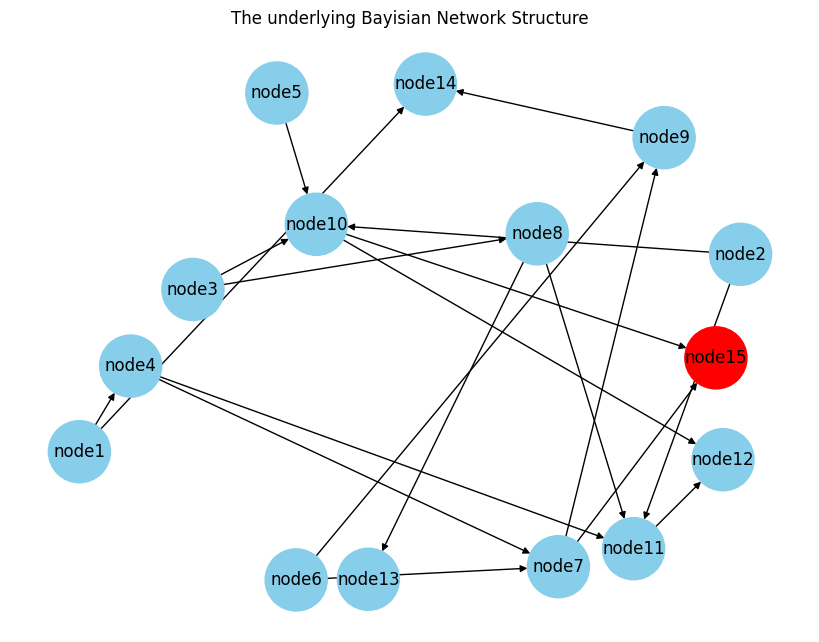

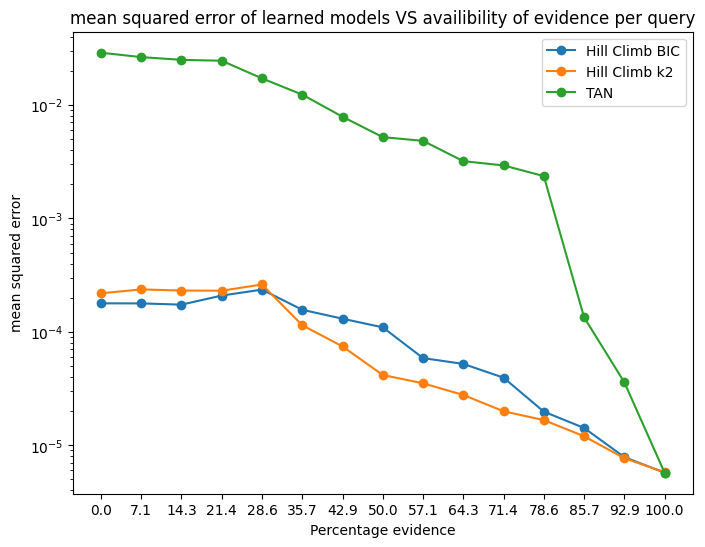

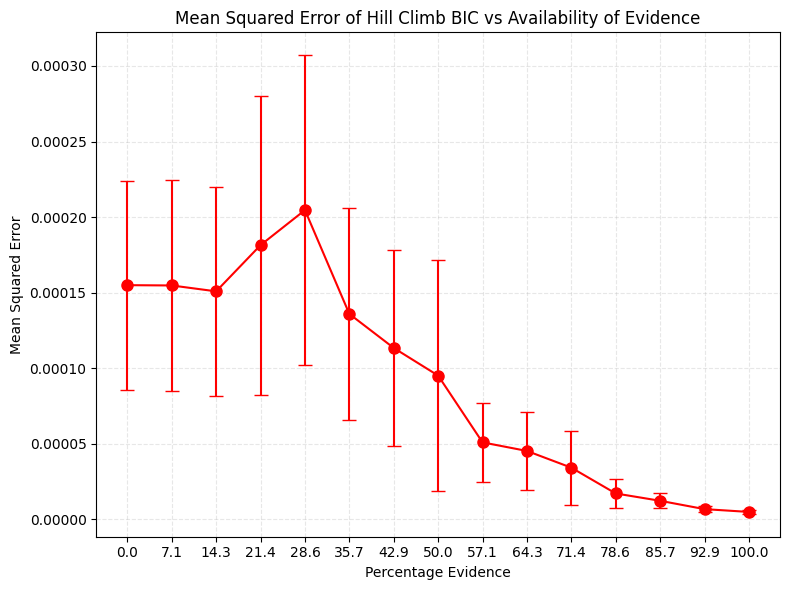

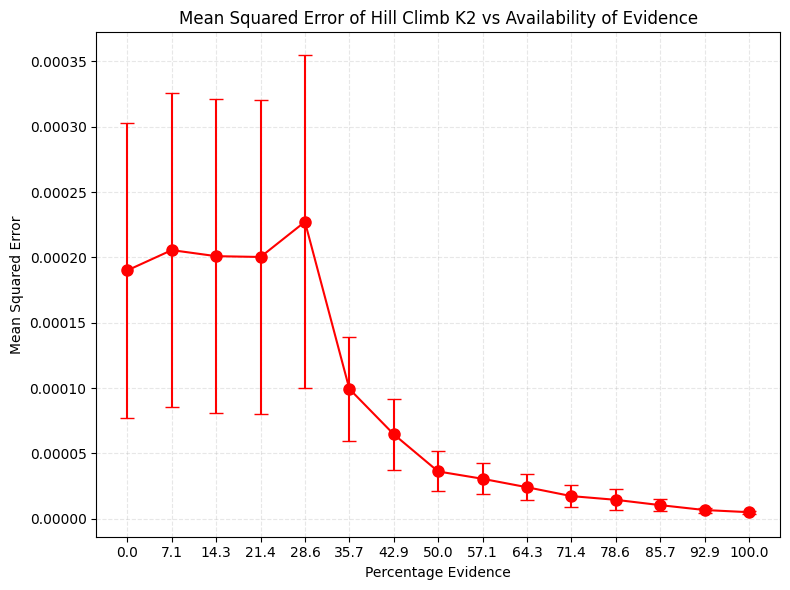

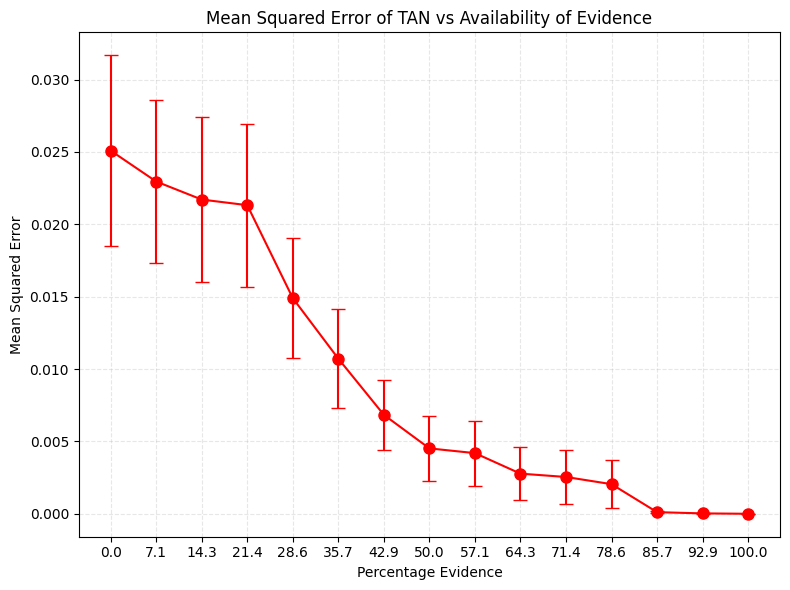

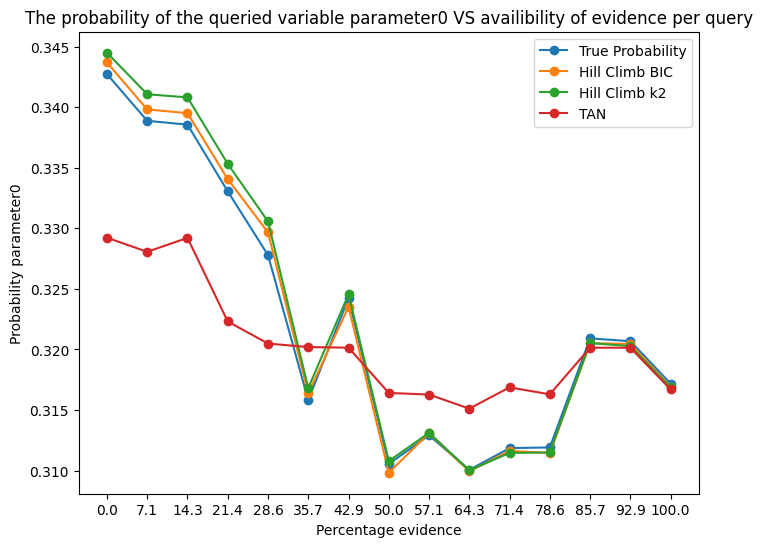

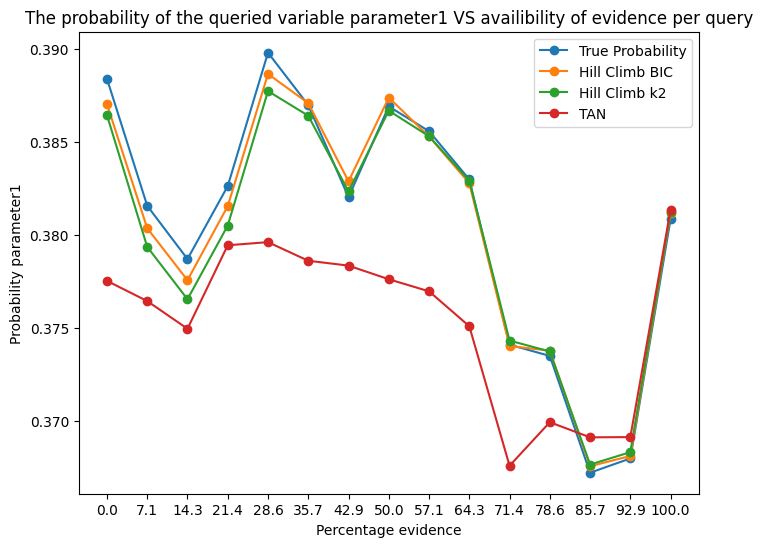

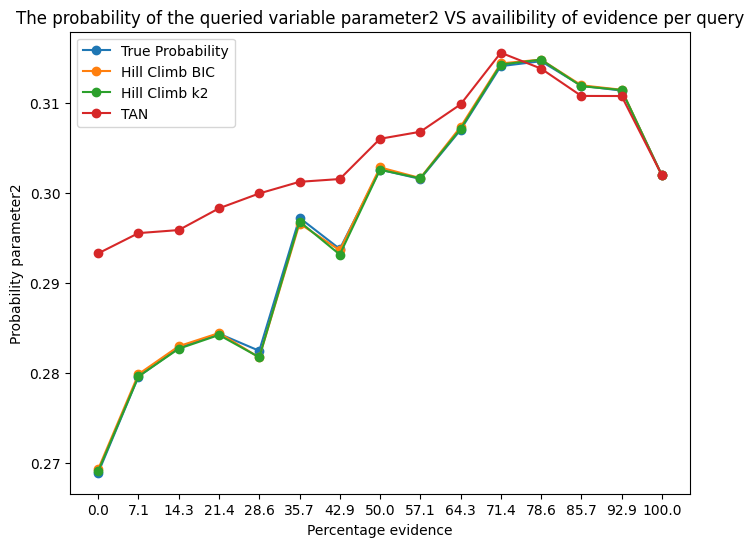

          .............................            
...... learning with different structure complexity
          .............................            
RUNNING FOR THE 0 Times


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 1 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 2 Times


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 3 Times


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 4 Times


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 5 Times


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 6 Times


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 7 Times


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 8 Times


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 9 Times


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 0 Times


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 1 Times


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 2 Times


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 3 Times


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 4 Times


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 5 Times


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 6 Times


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 7 Times


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 8 Times


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 9 Times


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 0 Times


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 1 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 2 Times


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 3 Times


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 4 Times


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 5 Times


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 6 Times


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 7 Times


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 8 Times


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 9 Times


  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

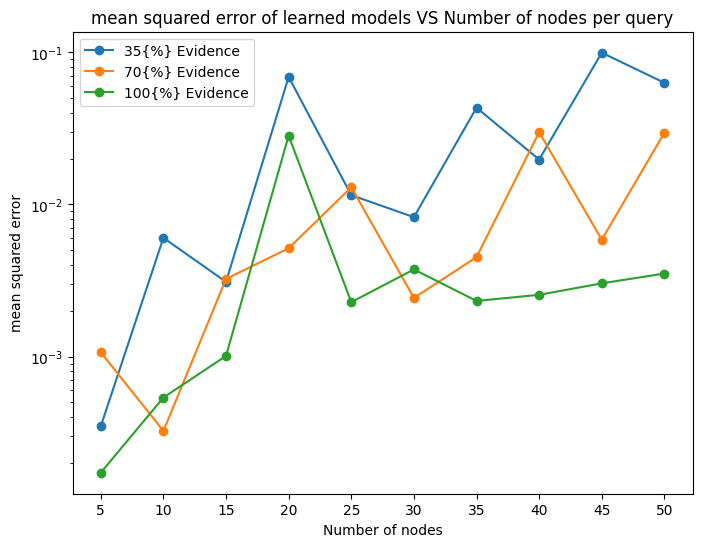

          .............................            
...... learning with different dataset complexity
          .............................            
RUNNING FOR THE 0 Times


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 1 Times


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 2 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 3 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 4 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 5 Times


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 6 Times


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 7 Times


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 8 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

RUNNING FOR THE 9 Times


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

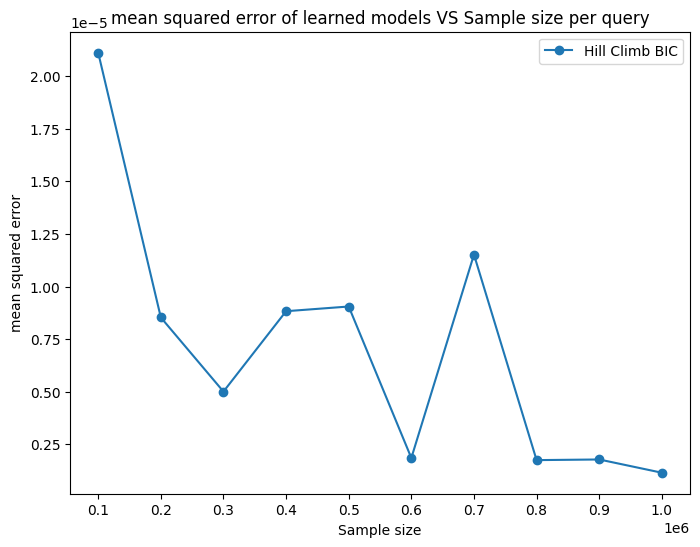

Time taken: 2640.0706703662872


In [37]:
if __name__ == "__main__":
    main()